In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    @property
    def latest(self):
        fmtstr = '{name} {val' + self.fmt + '}'
        return fmtstr.format(**self.__dict__)

    def __str__(self):
        fmtstr = 'Avg {name} {avg' + self.fmt + '}'
        return fmtstr.format(**self.__dict__)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

# 实战：训练图像分类器

我们将上一节的内容投入实战，训练一个图像分类器来对 CIFAR10 数据集中的图像进行分类。


## 1. 加载和标准化 CIFAR-10

CIFAR-10 是一个常用的数据集，包含 10 个类别的 60000 张 32x32 的彩色图像。训练集中每个类别有 5000 张图像，测试集中每个类别有 1000 张图像。

![CIFAR-10 数据集中的图像示例](https://pytorch.org/tutorials/_images/cifar10.png)

我们将使用 torchvision 来加载 CIFAR-10 数据集。

我们还需要对数据进行归一化、标准化。归一化即将数据映射到 $[0,1]$ 区间，标准化即将数据映射到均值为 0，标准差为 1 的分布中（减去均值，再除以标准差）。


In [3]:
import torchvision
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomResizedCrop((224, 224)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224, 224)),
])

batch_size = 64 # 批处理大小

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform) # 下载训练数据集
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2) # 加载训练数据集

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform) # 下载测试数据集
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2) # 加载测试数据集

classes = (
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "cra",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm",
) # 类别


Files already downloaded and verified
Files already downloaded and verified


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. 定义卷积神经网络

这一次，我们需要将上一节的神经网络改为接受 RGB 三个通道的图像，而不是单通道的图像。


In [5]:
import torch.nn as nn
import torch.nn.functional as F

model = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')

model.train()

model.heads.head = nn.Linear(768, 100)

model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## 3. 定义损失函数和优化器


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## 4. 训练网络


In [7]:
def test():
	correct = 0
	total = 0
	# 因为我们不需要进行梯度计算，所以我们使用 torch.no_grad() 来减少内存开销
	with torch.no_grad():
		for data in testloader:
			inputs, labels = data
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			_, predicted = torch.max(outputs.data, 1) # 取得分最高的那个类 (outputs.data 的索引号)
			total += labels.size(0) # 统计测试数据集的数量
			correct += (predicted == labels).sum().item() # 统计预测正确的数量
	print(f'10000 测试集的准确率: {100 * correct // total} %')

optimSGD = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimAdam = optim.Adam(model.parameters(), lr=0.0001)

def train(epoches=4, optimizer=optimSGD):
	for epoch in range(epoches):  # 循环遍历数据集多次
		running_loss = AverageMeter(name='running_loss', fmt=':f')
		train_acc1 = AverageMeter(name='train_acc1', fmt=':f')
		train_acc5 = AverageMeter(name='train_acc5', fmt=':f')
		for i, (inputs, labels) in enumerate(trainloader, 0):
			inputs, labels = inputs.to(device), labels.to(device)
			optimizer.zero_grad()

			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()

			train_acc1.update(accuracy(outputs, labels, topk=(1,))[0][0])
			train_acc5.update(accuracy(outputs, labels, topk=(5,))[0][0])
			running_loss.update(loss.item())
			print(f"Epoch: {epoch + 1},\tTrain batch: {i + 1:3}/{len(trainloader):3},\tLoss: {running_loss},\tAcc1: {train_acc1},\tAcc5: {train_acc5}", end='\r')
		test()
	print('Finished Training')

train(4, optimAdam)

/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent

/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent

10000 测试集的准确率: 78 %


/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent

/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent

10000 测试集的准确率: 81 %


/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent

/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent

10000 测试集的准确率: 82 %


/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent

/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent

10000 测试集的准确率: 83 %
Finished Training


保存训练好的模型


In [8]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)


## 5. 在测试集上测试网络


准备


In [9]:
model = torchvision.models.vit_b_16()
model.heads.head = nn.Linear(768, 100)
model.load_state_dict(torch.load(PATH))

import matplotlib.pyplot as plt
import numpy as np

# 显示图像的函数
def imshow(img):
    img = img / 2 + 0.5  # 去归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


第一个 batch 展示


/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent

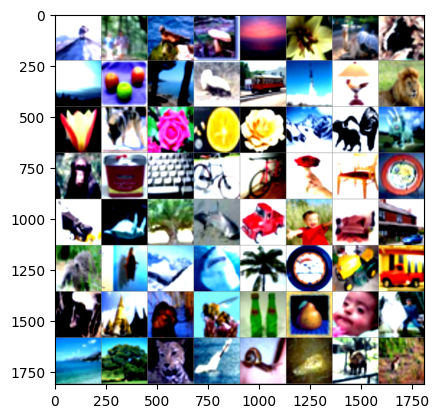

GroundTruth:  mountain forest seal  mushroom


In [10]:
dataiter = iter(testloader) # 获取测试数据集的迭代器
inputs, labels = next(dataiter) # 获取测试数据集的第一个 batch

imshow(torchvision.utils.make_grid(inputs))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:12s}' for j in range(batch_size)))


总准确率


In [12]:
correct = 0
total = 0
# 因为我们不需要进行梯度计算，所以我们使用 torch.no_grad() 来减少内存开销
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1) # 取得分最高的那个类 (outputs.data 的索引号)
        total += labels.size(0) # 统计测试数据集的数量
        correct += (predicted == labels).sum().item() # 统计预测正确的数量

print(f'10000 测试集的准确率: {100 * correct // total} %')


/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent

10000 测试集的准确率: 83 %


每个类别的准确率

In [13]:
# 统计每个类别的预测情况
# 形式为字典：{类别名称: 数量}
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
		# zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的对象
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:12s} is {accuracy:.1f} %')


/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent

Accuracy for class: apple is 86.0 %
Accuracy for class: aquarium_fish is 94.0 %
Accuracy for class: baby  is 76.0 %
Accuracy for class: bear  is 82.0 %
Accuracy for class: beaver is 77.0 %
Accuracy for class: bed   is 85.0 %
Accuracy for class: bee   is 85.0 %
Accuracy for class: beetle is 79.0 %
Accuracy for class: bicycle is 87.0 %
Accuracy for class: bottle is 93.0 %
Accuracy for class: bowl  is 68.0 %
Accuracy for class: boy   is 68.0 %
Accuracy for class: bridge is 88.0 %
Accuracy for class: bus   is 85.0 %
Accuracy for class: butterfly is 85.0 %
Accuracy for class: camel is 85.0 %
Accuracy for class: can   is 81.0 %
Accuracy for class: castle is 83.0 %
Accuracy for class: caterpillar is 84.0 %
Accuracy for class: cattle is 82.0 %
Accuracy for class: chair is 89.0 %
Accuracy for class: chimpanzee is 95.0 %
Accuracy for class: clock is 91.0 %
Accuracy for class: cloud is 84.0 %
Accuracy for class: cockroach is 91.0 %
Accuracy for class: couch is 86.0 %
Accuracy for class: cra   is 